In [1]:
import os
import random

from PIL import Image

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import itertools
import torch
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

### Dataset Creation

In [5]:
# Constants taken from data_helper.py
NUM_SAMPLE_PER_SCENE = 126
NUM_IMAGE_PER_SAMPLE = 6
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

# Unlabeled scenes
val_unlabeled_scene_index = np.arange(80,106)
train_unlabeled_scene_index = np.arange(80)

# Image folder
image_folder = '/scratch/brs426/data'
first_dim = 'image'

# Option 1
CROP_SIZE = 225
PATCH_SIZE = 64

# Option 2
# CROP_SIZE = 150
# PATCH_SIZE = 32

# Transforms
transform = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(CROP_SIZE),torchvision.transforms.ToTensor()])

In [ ]:
# Get maximal Hamming permutations
# N is the number of permutations to return (subsample size)
# k are the permutations (k!)
# TODO: Speed up
def get_maximal_Hamming_permutation_set(N,k):
    # Generate all permutations and convert to matrix
    perms = list(itertools.permutations(range(k)))
    perms = np.array(perms).T
    
    # Get random index
    idx = np.random.randint(0, len(perms))
    
    # Counter
    i = 1
    
    # Get corresponding permutation and reshape to be 3d for broadcasting
    p = perms[:, idx].T
    p = p.reshape(i, k, -1)
    
    # Remove permutation to prevent resampling
    perms = np.concatenate((perms[:, 0:idx],perms[:, idx+1:]), axis=1)
    
    # Compute Hamming distance where resulting matrix is num_perms x num_remaining_perms
    while i <= N-1:
        # Compute Hamming distance
        hamming_dist = np.count_nonzero(p != perms, axis=1)
        ones = np.ones(i)
        dist = np.dot(ones, hamming_dist)
        # Get next index
        idx = np.argmax(dist)
        # Get corresponding permutation
        new_p = perms[:, idx].T
        # Reshape and append
        new_p = new_p.reshape(1, k, -1)
        p = np.append(p, new_p, axis=0)
        # Increment
        i += 1
        # Remove
        perms = np.concatenate((perms[:, 0:idx], perms[:, idx+1:]), axis=1)
    p = p.reshape(N, k).tolist()
    return p

In [ ]:
PERMUTATION_LIMIT = 100
permutations = get_maximal_Hamming_permutation_set(PERMUTATION_LIMIT, 9)

In [6]:
# Based off of the UnlabeledDataset in data_helper.py
# Creates: grid_size x grid_size of cells that have cell_size x cell_size
# In each cell, we randomly extract a patch of patch_size x patch_size
# TODO: Make sure crop_size, grid_size, cell_size, and patch_size are compatible
# TODO: Probably need to clean up a little. Especially patch creation.
class JigsawPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, scene_index, transform, patch_size, cell_size, grid_size, permutations):
        """
        Args:
            image_folder (string): the location of the image folder
            scene_index (list): a list of scene indices for the unlabeled data 
            first_dim ({'sample', 'image'}):
                'sample' will return [batch_size, NUM_IMAGE_PER_SAMPLE, 3, H, W]
                'image' will return [batch_size, 3, H, W] and the index of the camera [0 - 5]
                    CAM_FRONT_LEFT: 0
                    CAM_FRONT: 1
                    CAM_FRONT_RIGHT: 2
                    CAM_BACK_LEFT: 3
                    CAM_BACK.jpeg: 4
                    CAM_BACK_RIGHT: 5
            transform (Transform): The function to process the image
        """

        self.image_folder = image_folder
        self.scene_index = scene_index
        self.transform = transform
        self.patch_size = patch_size
        self.cell_size = cell_size
        self.grid_size = grid_size
        assert first_dim in ['sample', 'image']
        self.first_dim = first_dim
        self.permutations = permutations
        
        # Number of examples
        self.length = self.scene_index.size * NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE
        
        # Differential between patch_size and grid cell size
        self.diff = self.cell_size - self.patch_size
        
        # List to store differentials to get patches from cells.
        # Set differentials so none of patches will be on the boundary
        self.x_diff = [random.randint(1, self.diff-2) for i in range(self.length)]
        self.y_diff = [random.randint(1, self.diff-2) for i in range(self.length)]
        
        # List to store the permutation for each image
        self.idx_permutations = [random.randint(0, len(self.permutations)-1) for i in range(self.length)]

    def __len__(self):
        return self.scene_index.size * NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE
    
    def __getitem__(self, index):
        scene_id = self.scene_index[index // (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)]
        sample_id = (index % (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)) // NUM_IMAGE_PER_SAMPLE
        image_name = image_names[index % NUM_IMAGE_PER_SAMPLE]

        image_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}', image_name) 
        image = Image.open(image_path)
        image = self.transform(image)
        patches = []
        diff_x = self.x_diff[index]
        diff_y = self.y_diff[index]
        permutation = self.permutations[self.idx_permutations[index]]
        # Create random patch from grid cell
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                patch = image[:, self.cell_size*j:self.cell_size*(j+1), self.cell_size*i:self.cell_size*(i+1)]
                patch = patch[:, diff_x:diff_x+self.patch_size, diff_y:diff_y+self.patch_size]
                patches.append(patch)
        patch_tensor = torch.stack(patches)
        # Permute
        patch_tensor = patch_tensor[permutation, :, :, :]
        
        # Return patch tensor and permutation
        return patch_tensor, self.idx_permutations[index]

In [7]:
train_jigsaw = JigsawPredictionDataset(image_folder, train_unlabeled_scene_index, transform, patch_size=64, cell_size=75, grid_size=3, permutations=permutations)
val_jigsaw = JigsawPredictionDataset(image_folder, val_unlabeled_scene_index, transform, patch_size=64, cell_size=75, grid_size=3, permutations=permutations)

In [8]:
jigsaw_train_loader = torch.utils.data.DataLoader(train_jigsaw, batch_size=64, shuffle=True, num_workers=4)
jigsaw_val_loader = torch.utils.data.DataLoader(val_jigsaw, batch_size=64, shuffle=True, num_workers=4)

### Model Architecture

In [37]:
# Create resnet-based model
# Resnet outputs unnormalized scores for 1000 class classification problem
# Specify any of the available ResNet models and load them in
class ResNetModel(nn.Module):
    def __init__(self, resnet, num_classes, hidden_size):
        super(ResNetModel, self).__init__()
        if resnet not in [18, 34, 50, 101, 152]:
            raise Excpetion("Invalid resnet size")
        self.resnet = getattr(models, "resnet{}".format(resnet))()
        self.fc1 = nn.Linear(1000, hidden_size)
        # Mutliply by 9 because we are concatenating the representations for each image together
        self.fc2 = nn.Linear(9 * hidden_size, num_classes)
    
    def forward(self, x):
        # Input x is (Batch x Number of Images x Channels x Height x Width)
        batch = x.shape[0]
        channels = x.shape[2]
        height = x.shape[3]
        width = x.shape[4]
        x = x.reshape(-1, channels, height, width)
        # Now our input is ((Batch x Number of Images) x Channels x Height x Width)
        x = F.relu(self.resnet(x))
        x = F.relu(self.fc1(x))
        # Now we need to recast to have original batch size (should double check this)
        x = x.reshape(batch, -1)
        x = self.fc2(x)
        return x

### Training Logic

In [31]:
# Train logic, return average loss over training set after each epoch
def train(model, device, train_loader, optimizer, epoch, log_interval = 250):
    # Set model to training mode
    model.train()
    
    # Number correct for accuracy
    num_correct = 0
    
    # Train loss
    train_loss = 0
    
    # Loop through examples
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Send data and target to device
        data, target = data.to(device), target.to(device)
        
        # Zero out optimizer
        optimizer.zero_grad()
        
        # Pass data through model
        output = model(data)
        predictions = torch.argmax(output, 1)
        num_correct += torch.sum(predictions == target).item()
        
        # Compute the loss
        loss = F.cross_entropy(output, target)
        train_loss += loss.item()
        
        # Backpropagate loss
        loss.backward()
        
        # Make a step with the optimizer
        optimizer.step()
        
        # Print loss (uncomment lines below once implemented)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    
    # Average train loss
    average_train_loss = train_loss / len(train_loader)
    # Print loss (uncomment lines below once implemented)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        average_train_loss, num_correct, len(train_loader.dataset),
        100. * num_correct / len(train_loader.dataset)))

### Validation Logic

In [32]:
# Define test method
def test(model, device, test_loader):
    # Set model to evaluation mode
    model.eval()
    # Variable for the total loss 
    test_loss = 0
    # Counter for the correct predictions
    num_correct = 0
    
    # don't need autograd for eval
    with torch.no_grad():
        # Loop through data points
        for data, target in test_loader:
            pass # remove once implemented
        
            # Send data to device
            data, target = data.to(device), target.to(device)
            
            # Pass data through model
            output = model(data)
            
            # Compute the negative log likelihood loss with reduction='sum' and add to total test_loss
            loss = F.cross_entropy(output, target, reduction='sum')
            test_loss += loss.item()
            
            # Get predictions from the model for each data point
            predictions = torch.argmax(output, 1)

            # Add number of correct predictions to total num_correct 
            num_correct += torch.sum(predictions == target).item()
            
    
    # Compute the average test_loss
    # avg_test_loss = TODO
    avg_test_loss = test_loss / len(test_loader.dataset)
    
    # Print loss (uncomment lines below once implemented)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_test_loss, num_correct, len(test_loader.dataset),
        100. * num_correct / len(test_loader.dataset)))
    
    return avg_test_loss

In [38]:
# ResNet model
res = ResNetModel(50,1000, 256).to(device)

# Optimizer
optimizer = optim.Adam(res.parameters(), lr=3e-4)

In [ ]:
best_val_loss = None
save_path = "/scratch/brs426/ben_models/resnet50_jigsaw_single_image_1000_permutations_SSL_checkpoint.p"
epochs = 20
for epoch in range(1, epochs + 1):
    # Train model
    train(res, device, jigsaw_train_loader, optimizer, epoch)
    val_loss = test(res, device, jigsaw_val_loader)
    # Save model
    if best_val_loss is None:
        torch.save({'model_state_dict': res.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': val_loss}, save_path)
        best_val_loss = val_loss

Train Epoch: 1 [0/60480 (0%)]	Loss: 6.890244
Train Epoch: 1 [16000/60480 (26%)]	Loss: 1.647320
Train Epoch: 1 [32000/60480 (53%)]	Loss: 1.057196
Train Epoch: 1 [48000/60480 (79%)]	Loss: 0.803101

Train set: Average loss: 2.1807, Accuracy: 31462/60480 (52%)


Test set: Average loss: 1.1862, Accuracy: 12168/19656 (62%)

Train Epoch: 2 [0/60480 (0%)]	Loss: 0.746082
Train Epoch: 2 [16000/60480 (26%)]	Loss: 0.800040
Train Epoch: 2 [32000/60480 (53%)]	Loss: 0.529827
Train Epoch: 2 [48000/60480 (79%)]	Loss: 0.503506

Train set: Average loss: 0.6384, Accuracy: 45656/60480 (75%)


Test set: Average loss: 0.7035, Accuracy: 14977/19656 (76%)

Train Epoch: 3 [0/60480 (0%)]	Loss: 0.473989
Train Epoch: 3 [16000/60480 (26%)]	Loss: 0.665672
Train Epoch: 3 [32000/60480 (53%)]	Loss: 0.509801
Train Epoch: 3 [48000/60480 (79%)]	Loss: 0.363237

Train set: Average loss: 0.4269, Accuracy: 50912/60480 (84%)


Test set: Average loss: 0.5185, Accuracy: 16306/19656 (83%)

Train Epoch: 4 [0/60480 (0%)]	Loss: 0.23

6
5
0
3
0
0
8
9
1
3
1
9
3
4
4
2
1
7


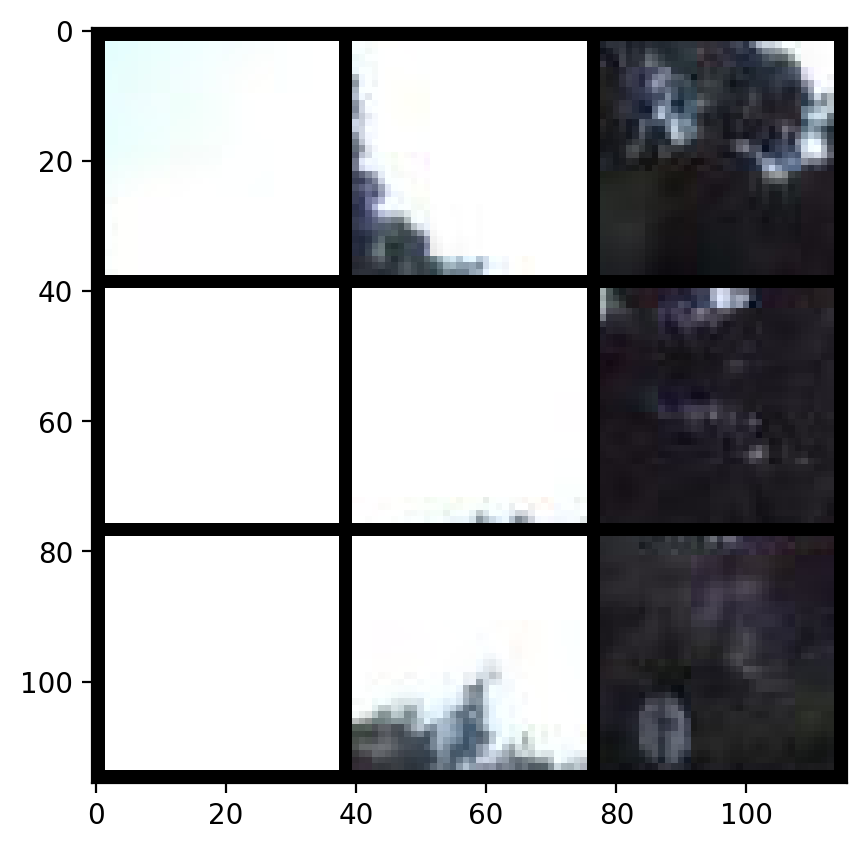

In [51]:
# Generation of maximal Hamming distance permutation set


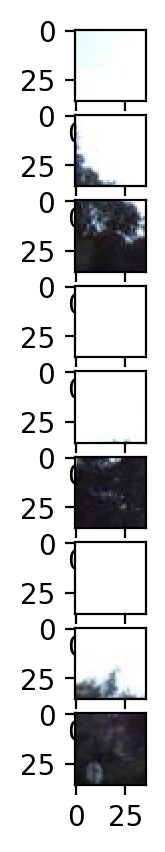

In [52]:
fig, (ax1, ax2, ax3, ax4 ,ax5, ax6, ax7, ax8, ax9) = plt.subplots(9,1)
ax1.imshow(patches[0].numpy().transpose(1,2,0))
ax2.imshow(patches[1].numpy().transpose(1,2,0))
ax3.imshow(patches[2].numpy().transpose(1,2,0))
ax4.imshow(patches[3].numpy().transpose(1,2,0))
ax5.imshow(patches[4].numpy().transpose(1,2,0))
ax6.imshow(patches[5].numpy().transpose(1,2,0))
ax7.imshow(patches[6].numpy().transpose(1,2,0))
ax8.imshow(patches[7].numpy().transpose(1,2,0))
ax9.imshow(patches[8].numpy().transpose(1,2,0))

In [36]:
ax1.imshow(patches[0].numpy().transpose(1,2,0))
ax2.imshow(patches[1].numpy().transpose(1,2,0))